In [1]:
import pandas as pd

# data load

In [2]:
base_dir = './data/'

data = pd.read_csv(base_dir + 'custom_train.csv')
data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
# 'class' 값을 기준으로 'label' 컬럼 추가
label_dict = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

data['label'] = data['class'].map(label_dict)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           5050 non-null   int64 
 1   class         5050 non-null   object
 2   conversation  5050 non-null   object
 3   label         5050 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 157.9+ KB


In [4]:
# 전처리 함수
# 구분자 삭제
import re

def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = sentence.replace("\n", "")         # 구분자
    sentence = sentence.replace("\r", "")         # 구분자
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z,가-힣,0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣0-9\.\?\!,]"," ",sentence)
    sentence = sentence.strip()
    return sentence

In [5]:
data_prepcocessed = data.copy()
data_prepcocessed['conversation'] = data['conversation'].apply(preprocess_sentence)
data_prepcocessed['conversation'][0]

'지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 ? 진짜 죽여버리고 싶게 . 정말 잘못했습니다 . 너가 선택해 . 너가 죽을래 네 가족을 죽여줄까 . 죄송합니다 . 정말 잘못했습니다 . 너에게는 선택권이 없어 . 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 . 선택 못하겠습니다 . 한번만 도와주세요 . 그냥 다 죽여버려야겠군 . 이의 없지 ? 제발 도와주세요 .'

# tokenizer 사용 (konlpy Mecab)

In [6]:
data_prepcocessed.head()

,idx,class,conversation,label
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,0
1,1,협박 대화,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...,3
3,3,갈취 대화,어이 거기예 ? ? 너 말이야 너 . 이리 오라고무슨 일 . 너 옷 좋아보인다 ? ...,1
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,1


In [7]:
from konlpy.tag import Mecab
from collections import Counter
import numpy as np

tokenizer = Mecab()
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, num_words=10000):
    train_data.drop_duplicates(subset=['conversation'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['conversation']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        # temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
#     print(counter)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        # 사전에 없는건 <UNK>
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))

        
    return X_train, np.array(list(train_data['label'])), word_to_index
    
    
# X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
X_train, y_train, word_to_index = load_data(data_prepcocessed)

In [8]:
print('word_to_index')
print(word_to_index)

word_to_index
{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '<UNUSED>': 3, '.': 4, '?': 5, '하': 6, '이': 7, '는': 8, '가': 9, '고': 10, '야': 11, '에': 12, '!': 13, '어': 14, '도': 15, '아': 16, '거': 17, '네': 18, '지': 19, '나': 20, '있': 21, '저': 22, '을': 23, '너': 24, '은': 25, '안': 26, '내': 27, '게': 28, '해': 29, '다': 30, '면': 31, '말': 32, '어요': 33, '겠': 34, '없': 35, '아니': 36, '세요': 37, '만': 38, '주': 39, '시': 40, '한': 41, '왜': 42, '일': 43, '들': 44, '좀': 45, '습니다': 46, '를': 47, '님': 48, '니': 49, '뭐': 50, '는데': 51, '좋': 52, '알': 53, '네요': 54, '보': 55, '잘': 56, '돈': 57, '같': 58, '했': 59, '죄송': 60, '요': 61, '합니다': 62, '되': 63, '제': 64, '로': 65, '못': 66, '할': 67, '것': 68, '지금': 69, '냐': 70, '진짜': 71, '그러': 72, '라고': 73, '서': 74, '기': 75, '으로': 76, '나요': 77, '죠': 78, '먹': 79, '그럼': 80, '무슨': 81, '한테': 82, '에서': 83, '었': 84, '우리': 85, '봐': 86, '그래': 87, '맞': 88, '너무': 89, '싶': 90, '사람': 91, '셨': 92, '그': 93, '오늘': 94, '그냥': 95, '입니다': 96, '대': 97, '아요': 98, '해요': 99, '수': 100, '라': 101, '죽': 102, '시간': 103, '않': 

In [40]:
index_to_word = {index:word for word, index in word_to_index.items()}
print('index_to_word')
print(index_to_word)

index_to_word
{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '<UNUSED>', 4: '.', 5: '?', 6: '하', 7: '이', 8: '는', 9: '가', 10: '고', 11: '야', 12: '에', 13: '!', 14: '어', 15: '도', 16: '아', 17: '거', 18: '네', 19: '지', 20: '나', 21: '있', 22: '저', 23: '을', 24: '너', 25: '은', 26: '안', 27: '내', 28: '게', 29: '해', 30: '다', 31: '면', 32: '말', 33: '어요', 34: '겠', 35: '없', 36: '아니', 37: '세요', 38: '만', 39: '주', 40: '시', 41: '한', 42: '왜', 43: '일', 44: '들', 45: '좀', 46: '습니다', 47: '를', 48: '님', 49: '니', 50: '뭐', 51: '는데', 52: '좋', 53: '알', 54: '네요', 55: '보', 56: '잘', 57: '돈', 58: '같', 59: '했', 60: '죄송', 61: '요', 62: '합니다', 63: '되', 64: '제', 65: '로', 66: '못', 67: '할', 68: '것', 69: '지금', 70: '냐', 71: '진짜', 72: '그러', 73: '라고', 74: '서', 75: '기', 76: '으로', 77: '나요', 78: '죠', 79: '먹', 80: '그럼', 81: '무슨', 82: '한테', 83: '에서', 84: '었', 85: '우리', 86: '봐', 87: '그래', 88: '맞', 89: '너무', 90: '싶', 91: '사람', 92: '셨', 93: '그', 94: '오늘', 95: '그냥', 96: '입니다', 97: '대', 98: '아요', 99: '해요', 100: '수', 101: '라', 102: '죽', 103: '시간', 104: 

In [9]:
total_data_text = list(X_train)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이 평균, 최대, 표준편차
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2.5*표준편차)
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {100 * np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함. ')

문장길이 평균 :  118.99555106167847
문장길이 최대 :  451
문장길이 표준편차 :  47.58651936741359
pad_sequences maxlen :  237
전체 문장의 96.96663296258848%가 maxlen 설정값 이내에 포함. 


# padding & one-hot encoding

In [10]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # LSTM이라 pre
                                                        maxlen=maxlen)
print(X_train.shape)
# 다중분류 라벨 원핫인코딩
y_train = tf.keras.utils.to_categorical(y_train)
print(y_train.shape)

(4945, 237)
(4945, 5)


# train, val 데이터셋 쪼개기

In [11]:
# 8:2 정도로 분리
len_data = int(len(X_train)*0.8)

x = X_train[:len_data]   
y = y_train[:len_data]

print(x.shape)
print(y.shape)

# # validation set을 제외한 나머지 29182건
x_val = X_train[:len_data]   
y_val = y_train[:len_data]

print(x_val.shape)
print(y_val.shape)

(3956, 237)
(3956, 5)
(3956, 237)
(3956, 5)


# 모델구성 및 훈련

In [19]:
import keras.backend as K

K.clear_session()


vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
# model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 2,757,765
Trainable params: 2,757,765
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stopping = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2, mode = 'auto')]

model.compile(optimizer='adam',
              loss='categorical_crossentropy', # 다중분류
              metrics=['accuracy'])
              
epochs=50

history = model.fit(x,
                    y,
                    epochs=epochs,
                    callbacks = [early_stopping],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/50
124/124 [==============================] - 4s 19ms/step - loss: 1.1535 - accuracy: 0.5131 - val_loss: 0.6702 - val_accuracy: 0.7647
Epoch 2/50
124/124 [==============================] - 2s 16ms/step - loss: 0.7120 - accuracy: 0.7401 - val_loss: 0.4462 - val_accuracy: 0.8420
Epoch 3/50
124/124 [==============================] - 2s 16ms/step - loss: 0.4082 - accuracy: 0.8668 - val_loss: 0.3199 - val_accuracy: 0.8959
Epoch 4/50
124/124 [==============================] - 2s 16ms/step - loss: 0.2221 - accuracy: 0.9335 - val_loss: 0.3711 - val_accuracy: 0.8577
Epoch 5/50
124/124 [==============================] - 2s 16ms/step - loss: 0.1814 - accuracy: 0.9429 - val_loss: 0.0713 - val_accuracy: 0.9788
Epoch 6/50
124/124 [==============================] - 2s 15ms/step - loss: 0.1109 - accuracy: 0.9704 - val_loss: 0.0619 - val_accuracy: 0.9884
Epoch 7/50
124/124 [==============================] - 2s 16ms/step - loss: 0.0576 - accuracy: 0.9863 - val_loss: 0.0260 - val_accuracy: 0.9929

# 훈련과정 시각화

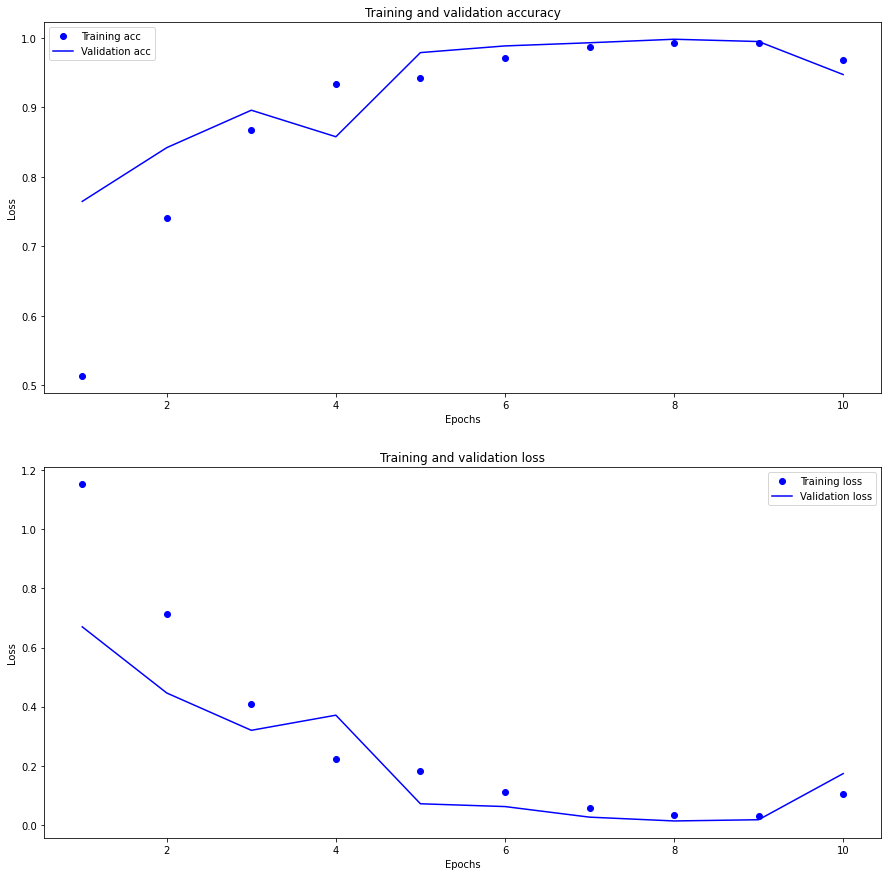

In [41]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(15,15))

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# accuracy
plt.subplot(211)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# loss
plt.subplot(212)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [35]:
# 잠시 테스트용
new_sentence = x_val[0]

predictions = model.predict(new_sentence)

In [36]:
predictions.shape

(237, 5)

In [37]:
predictions[0].shape

(5,)

In [38]:
np.argmax(predictions[0])

3

# 테스트 데이터 예측

In [43]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [50]:
test = pd.read_csv('./data/custom_test.csv')
test.head()

0    아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1    우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? ...
2    너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3    이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4    아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
Name: conversation, dtype: object

## 눈으로 확인

In [55]:
check_test = list(test['conversation'].sample(10))
check_test

['100원만 빌려주라 구라치네 내일 200원로 갚을게 밀린 돈이 니가 천원이 넘어 아니 우리 친구잖아 친구긴 하냐? 아 백원만 이번만이다 진짜 고마워 안 갚으면 죽인다',
 '오빠 나 생일선물 뭐 해줄거야 뭐 받고싶어 나 명품빽사줘 아 내가 어떻게 명품백을 사주냐 장난이야 나랑 분위기 좋은 식당가자 음 그럼 강남에 저번 거기갈까 저번 거기가 어디지 그 강남역 근처에 있던곳인데 이름이 기억안나네 하여튼 막 스테이크팔고 이런곳 가고싶어 그래 내가 한번 알아볼께',
 '너 살 빼야겠다 살 빼야 겠지 나는 먹어도 잘 살도 안 찌는데 그래 좋겠다 너는 먹으면 살 찌는 편이니 뭐 그런 편이야 너는 공부 잘하니 아니 너 나한테 고마워 해야겠다 뚱뚱하고 공부도 못 하는데 친구 해 주잖아 그래 고맙다',
 '찬호야 꼬추 한번만 보자 그래 잘 컸나 보자 하지마 선생님한테 다 이를 거야 일러라 일러 일본놈 일러라 일러 일름보 하지마 일본에 가서 죽어라 하하하하 집에 갈래 왜? 삐졌어?',
 '왜자꾸 승질 건드려 아닌데 맞는데 아니거든 지금도 건드리거든 죽는다 진짜 왜 시비야 니가 심기건드리니까 죽고 싶은가보네 손봐줄까 아니 미안 고통스럽게 해줄께  제발 미안해',
 '이혼하자 우리 이혼? 누구 좋자고이혼해 너 그년만나러 가지? 너의 폭언과 폭행에 지쳤어.나 만나는 사람도 없어 거짓말하지마 내가 병신같아? 그런거 아니야 정말 이제는 지쳐서 그래 누굴 만날 힘도 없어 아 그래서 조강지처 버리고 가려고? 솔직히 말하자 너 그동안 결혼생활에 충실히 안하고 매일 경마장 가고 애들 밥도 제대로 안해줬잖아 애들은 내가 키울게 아 내가 경마장 다닌건 다 우리가족 잘 되라고 다닌거지 큰건하나 하면 되니까 제발 그만해 나 이제 지쳤어 아 그럼 나 버리고 간다고? 내가 나 버리면 너랑 우리새끼들 그냥 둘거같아? 그게 무슨말이야! 너 애엄마야 정신차려 니가 지금 나를 버린다는데 내가 제정신이겠어? 나도 쫓아가서 다 죽여버리고 나도 죽을거 야',
 '니가 오빠좀 도와줘라 내가 왜 엄마가 도와줘 너는 

In [59]:
check_to_vector = get_encoded_sentences(check_test,word_to_index)

for vector in check_to_vector:
    print(get_decoded_sentence(vector,index_to_word))

<UNK> <UNK> <UNK> 내일 <UNK> <UNK> 밀린 <UNK> 니가 <UNK> <UNK> 아니 우리 <UNK> <UNK> <UNK> 아 <UNK> <UNK> 진짜 고마워 안 <UNK> 죽인다
오빠 나 <UNK> 뭐 <UNK> 뭐 <UNK> 나 <UNK> 아 내가 어떻게 <UNK> <UNK> <UNK> <UNK> 분위기 <UNK> <UNK> 음 그럼 <UNK> 저번 <UNK> 저번 <UNK> <UNK> 그 강남역 <UNK> <UNK> <UNK> <UNK> 하여튼 막 <UNK> <UNK> <UNK> 그래 내가 한번 <UNK>
너 살 <UNK> 살 <UNK> 겠지 <UNK> <UNK> 잘 <UNK> 안 <UNK> 그래 <UNK> <UNK> <UNK> 살 <UNK> <UNK> 뭐 그런 <UNK> <UNK> 공부 <UNK> 아니 너 <UNK> 고마워 해야겠다 <UNK> <UNK> 못 <UNK> 친구 해 <UNK> 그래 <UNK>
<UNK> <UNK> <UNK> <UNK> 그래 잘 <UNK> <UNK> <UNK> <UNK> 다 이를 거야 일러라 일러 <UNK> 일러라 일러 <UNK> <UNK> <UNK> <UNK> <UNK> 하하하하 <UNK> 갈래 <UNK> <UNK>
<UNK> <UNK> 건드려 아닌데 <UNK> <UNK> <UNK> <UNK> <UNK> 진짜 왜 <UNK> 니가 <UNK> <UNK> <UNK> <UNK> 아니 미안 <UNK> <UNK> 제발 <UNK>
<UNK> 우리 <UNK> 누구 <UNK> 너 <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> 내가 <UNK> <UNK> 아니야 정말 <UNK> 지쳐서 그래 누굴 만날 <UNK> <UNK> 아 그래서 <UNK> <UNK> <UNK> 솔직히 <UNK> 너 그동안 <UNK> <UNK> <UNK> 매일 경마장 <UNK> <UNK> <UNK> 제대로 <UNK> <UNK> 내가 <UNK> 아 내가 경마장 <UNK> 다 <UNK> 잘 <UNK

## 예측

In [76]:
test_datas = get_encoded_sentences(test['conversation'],word_to_index)



X_test = tf.keras.preprocessing.sequence.pad_sequences(test_datas,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # LSTM이라 pre
                                                        maxlen=maxlen)

predictions = model.predict(X_test)

In [93]:
results = []
for pred in predictions:
    results.append(np.argmax(pred))

Counter(results)

Counter({3: 487, 1: 10, 2: 1, 4: 2})

## 예측결과 Counter로 세보니
- 3(기타 괴롭힘): 487개
- 1(갈취 대화): 10개
- 2(직장 내 괴롭힘 대화): 1개
- 4(일반 대화): 2개
- 0(협박 대화): 0개